# co

> Covariance and Coherence Matrix Estimation

In [ ]:
#| default_exp cli/co

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math

import zarr
import cupy as cp
import numpy as np
from matplotlib import pyplot as plt
import colorcet

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster
from dask_cuda import LocalCUDACluster

from decorrelation.co import emperical_co_sp
from decorrelation.cli.utils.logging import get_logger, log_args
from decorrelation.cli.utils.dask import pad_internal

from fastcore.script import call_parse

In [ ]:
#| export
@call_parse
@log_args
def de_emperical_co_sp(rslc:str, # input: rslc stack
                       ds_can_is_shp:str, # input: bool array indicating the SHPs of every pixel
                       ds_can_idx:str, # input: bool array indicating DS candidate
                       ds_can_coh:str, # output: complex coherence matrix for DS candidate
                       az_chunk_size:int=None, # azimuth chunk size, optional. Default: the azimuth chunk size in rslc stack
                       pt_chunk_size:int=None, # chunk size of output zarr dataset, optional. Default: same as ds_can_is_shp
                       ds_can_coh_ave_fig:str=None, # path to the plot of average coherence matrix of DS candidate, optional. Default: no plot
                       log=None, # log file. Default: no log file
                       ):
    rslc_path = rslc
    ds_can_is_shp_path = ds_can_is_shp
    ds_can_idx_path = ds_can_idx
    ds_can_coh_path = ds_can_coh
    logger = get_logger(logfile=log)

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.info('rslc dataset shape: '+str(rslc_zarr.shape))
    logger.info('rslc dataset chunks: '+str(rslc_zarr.chunks))
    assert rslc_zarr.ndim == 3, "rslc dimentation is not 3."

    ds_can_is_shp_zarr = zarr.open(ds_can_is_shp_path,mode='r')
    logger.info('ds_can_is_shp dataset shape: '+str(ds_can_is_shp_zarr.shape))
    logger.info('ds_can_is_shp dataset chunks: '+str(ds_can_is_shp_zarr.chunks))
    assert ds_can_is_shp_zarr.ndim == 3, "ds_can_is_shp dimentation is not 3."

    ds_can_idx_zarr = zarr.open(ds_can_idx_path,mode='r')
    logger.info('ds_can_idx dataset shape: '+str(ds_can_idx_zarr.shape))
    logger.info('ds_can_idx dataset chunks: '+str(ds_can_idx_zarr.chunks))
    assert ds_can_idx_zarr.ndim == 2, "ds_can_idx dimentation is not 2."
    logger.info('loading ds_can_idx into memory.')
    ds_can_idx = zarr.open(ds_can_idx_path,mode='r')[:]

    az_win, r_win = ds_can_is_shp_zarr.shape[1:]
    az_half_win = int((az_win-1)/2)
    r_half_win = int((r_win-1)/2)
    logger.info(f'got azimuth window size and half azimuth window size from is_shp shape: {az_win}, {az_half_win}')
    logger.info(f'got range window size and half range window size from is_shp shape: {r_win}, {r_half_win}')

    if not az_chunk_size:
        az_chunk_size = rslc_zarr.chunks[0]
        logger.info('using default parallel processing azimuth chunk size from rslc dataset.')
    logger.info('parallel processing azimuth chunk size: '+str(az_chunk_size))

    logger.info('starting dask CUDA local cluster.')
    cluster = LocalCUDACluster()
    client = Client(cluster)
    logger.info('dask local CUDA cluster started.')

    logger.info('create raster bool array is_ds_can from ds_can_idx')
    np_is_ds_can = np.zeros(rslc_zarr.shape[:2],dtype=bool)
    np_is_ds_can[(ds_can_idx[0],ds_can_idx[1])] = True
    logger.info('create dask bool array is_ds_can')
    cpu_is_ds_can = da.from_array(np_is_ds_can,chunks=(az_chunk_size,-1))
    logger.info('is_ds_can dask array shape: ' + str(cpu_is_ds_can.shape))
    logger.info('is_ds_can dask array chunks: '+ str(cpu_is_ds_can.chunks))
    
    logger.info('Using azimuth chunk size as the processing chunk size.')
    logger.info('Calculate point chunk size')
    cpu_ds_can_idx = da.nonzero(cpu_is_ds_can)
    idx_0 = cpu_ds_can_idx[0]
    process_pt_chunk_size = idx_0.compute_chunk_sizes().chunks[0]
    logger.info(f'Point chunk size: {process_pt_chunk_size}')

    cpu_rslc = da.from_zarr(rslc_path,chunks=(az_chunk_size,*rslc_zarr.shape[1:]))
    logger.info('rslc dask array shape: ' + str(cpu_rslc.shape))
    logger.info('rslc dask array chunks: '+ str(cpu_rslc.chunks))

    cpu_ds_can_is_shp = da.from_zarr(ds_can_is_shp_path,chunks=(process_pt_chunk_size,*ds_can_is_shp_zarr.shape[1:]))
    logger.info('ds_can_is_shp dask array shape: ' + str(cpu_ds_can_is_shp.shape))
    logger.info('ds_can_is_shp dask array chunks: '+ str(cpu_ds_can_is_shp.chunks))

    depth = {0:az_half_win, 1:r_half_win, 2:0}; boundary = {0:'none',1:'none',2:'none'}
    cpu_rslc_overlap = da.overlap.overlap(cpu_rslc,depth=depth, boundary=boundary)
    logger.info('setting shared boundaries between rlsc chunks.')
    logger.info(f'rslc dask array with overlap shape: {cpu_rslc_overlap.shape}')
    logger.info(f'rslc dask array with overlap chunks: {cpu_rslc_overlap.chunks}')

    depth = {0:az_half_win, 1:r_half_win}
    cpu_is_ds_can_padded = pad_internal(cpu_is_ds_can,depth=depth)
    logger.info('padding zero between is_ds_can chunks.')
    logger.info(f'is_ds_can dask array with padding shape: {cpu_is_ds_can_padded.shape}')
    logger.info(f'is_ds_can dask array with padding chunks: {cpu_is_ds_can_padded.chunks}')

    # logger.info('slicing is_shp on ds candidate.')
    # with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    #     cpu_ds_can_is_shp = cpu_is_shp.reshape(-1,az_win,r_win)[is_ds_can_result.reshape(-1)]
    # logger.info(f'ds_can_is_shp dask array shape: {cpu_ds_can_is_shp.shape}')
    # logger.info(f'ds_can_is_shp dask array chunks: {cpu_ds_can_is_shp.chunks}')

    logger.info(f'estimating coherence matrix.')
    rslc_overlap = cpu_rslc_overlap.map_blocks(cp.asarray)
    is_ds_can_padded = cpu_is_ds_can_padded.map_blocks(cp.asarray)
    ds_can_is_shp = cpu_ds_can_is_shp.map_blocks(cp.asarray)

    emperical_co_sp_delayed = delayed(emperical_co_sp,pure=True,nout=2)

    is_ds_can_padded_delayed = is_ds_can_padded.to_delayed()
    is_ds_can_padded_delayed = np.squeeze(is_ds_can_padded_delayed,axis=-1)
    rslc_overlap_delayed = rslc_overlap.to_delayed()
    rslc_overlap_delayed = np.squeeze(rslc_overlap_delayed,axis=(-2,-1))
    ds_can_is_shp_delayed = ds_can_is_shp.to_delayed()
    ds_can_is_shp_delayed = np.squeeze(ds_can_is_shp_delayed,axis=(-2,-1))

    ds_can_coh_delayed = np.empty_like(rslc_overlap_delayed,dtype=object)
    ds_can_idx_delayed = np.empty_like(rslc_overlap_delayed,dtype=object)

    nimage = rslc_overlap.shape[-1]
    with np.nditer(rslc_overlap_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
        for block in it:
            idx = it.multi_index
            ds_can_idx_delayed[idx] = delayed(cp.where)(is_ds_can_padded_delayed[idx])
            ds_can_coh_delayed[idx] = emperical_co_sp_delayed(rslc_overlap_delayed[idx],ds_can_idx_delayed[idx],ds_can_is_shp_delayed[idx])[1]
            chunk_shape = (ds_can_is_shp.blocks[idx].shape[0],nimage,nimage)
            dtype = rslc_overlap.dtype
            ds_can_coh_delayed[idx] = da.from_delayed(ds_can_coh_delayed[idx],shape=chunk_shape,meta=cp.array((),dtype=dtype))

    ds_can_coh = da.block(ds_can_coh_delayed.reshape(*ds_can_coh_delayed.shape,1,1).tolist())
    cpu_ds_can_coh = ds_can_coh.map_blocks(cp.asnumpy)
    logger.info(f'got coherence matrix.')

    # zarr do not support irregular chunk size
    if not pt_chunk_size:
        pt_chunk_size = math.ceil(ds_can_coh.shape[0]/ds_can_coh.numblocks[0])
    cpu_ds_can_coh = cpu_ds_can_coh.rechunk((pt_chunk_size,nimage,nimage))
    logger.info('rechunking ds_can_coh to chunk size (for saving with zarr): '+str(cpu_ds_can_coh.chunks))

    logger.info('saving ds_can_coh.')
    _cpu_ds_can_coh = cpu_ds_can_coh.to_zarr(ds_can_coh_path,overwrite=True,compute=False)

    cpu_ds_can_coh_ave = da.abs(cpu_ds_can_coh).mean(axis=0)

    logger.info('computing graph setted. doing all the computing.')
    # I haven't find the reason why this function is relatively slow.
    # the rechunking of the result takes more time, but other problem may also exist, may be the reshaping or persist.
    cpu_ds_can_coh_ave_result = da.compute(_cpu_ds_can_coh,cpu_ds_can_coh_ave)[1]

    logger.info('computing finished.')
    cluster.close()
    logger.info('dask cluster closed.')

    if ds_can_coh_ave_fig:
        logger.info('plotting average coherence matrix.')
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        pcm = ax.imshow(cpu_ds_can_coh_ave_result,cmap=colorcet.cm.fire)
        ax.set(title='Average Coherence Matrix',xlabel='Image Index',ylabel='Image Index')
        fig.colorbar(pcm)
        fig.show()
        fig.savefig(ds_can_coh_ave_fig)

In [ ]:
rslc = '../../data/rslc.zarr'
ds_can_is_shp = './ds_can_is_shp.zarr'
ds_can_idx = './ds_can_idx.zarr'
ds_can_coh = './ds_can_coh.zarr'
az_chunk_size = 1000
pt_coh_chunk_size = None
log = 'co.log'
ds_can_coh_ave_fig = './ds_can_coh_ave.png'

2023-09-20 19:44:14 - de_emperical_co_sp - INFO - fetching args:
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - rslc = '../../data/rslc.zarr'
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - ds_can_is_shp = './ds_can_is_shp.zarr'
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - ds_can_idx = './ds_can_idx.zarr'
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - ds_can_coh = './ds_can_coh.zarr'
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - az_chunk_size = None
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - pt_chunk_size = None
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - ds_can_coh_ave_fig = './ds_can_coh_ave.png'
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - log = 'co.log'
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - fetching args done.
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - rslc dataset shape: (2500, 1834, 17)
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - rslc dataset chunks: (1000, 1000, 17)
2023-09-20 19:44:14 - de_emperical_co_sp - INFO - ds_c

2023-09-20 19:44:16,969 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-09-20 19:44:16,969 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-09-20 19:44:16,969 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-09-20 19:44:16,969 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-09-20 19:44:16,969 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-09-20 19:44:16,969 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-09-20 19:44:16,969 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-09-20 19:44:16,969 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-09-20 19:44:16,969 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-09-20 19:44:16,969 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-09-20

2023-09-20 19:44:21 - de_emperical_co_sp - INFO - dask local CUDA cluster started.
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - create raster bool array is_ds_can from ds_can_idx
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - create dask bool array is_ds_can
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - is_ds_can dask array shape: (2500, 1834)
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - is_ds_can dask array chunks: ((1000, 1000, 500), (1834,))
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - Using azimuth chunk size as the processing chunk size.
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - Calculate point chunk size
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - Point chunk size: (346329, 274921, 119147)
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - rslc dask array shape: (2500, 1834, 17)
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - rslc dask array chunks: ((1000, 1000, 500), (1834,), (17,))
2023-09-20 19:44:21 - de_emperical_co_sp - INFO - ds_can_is

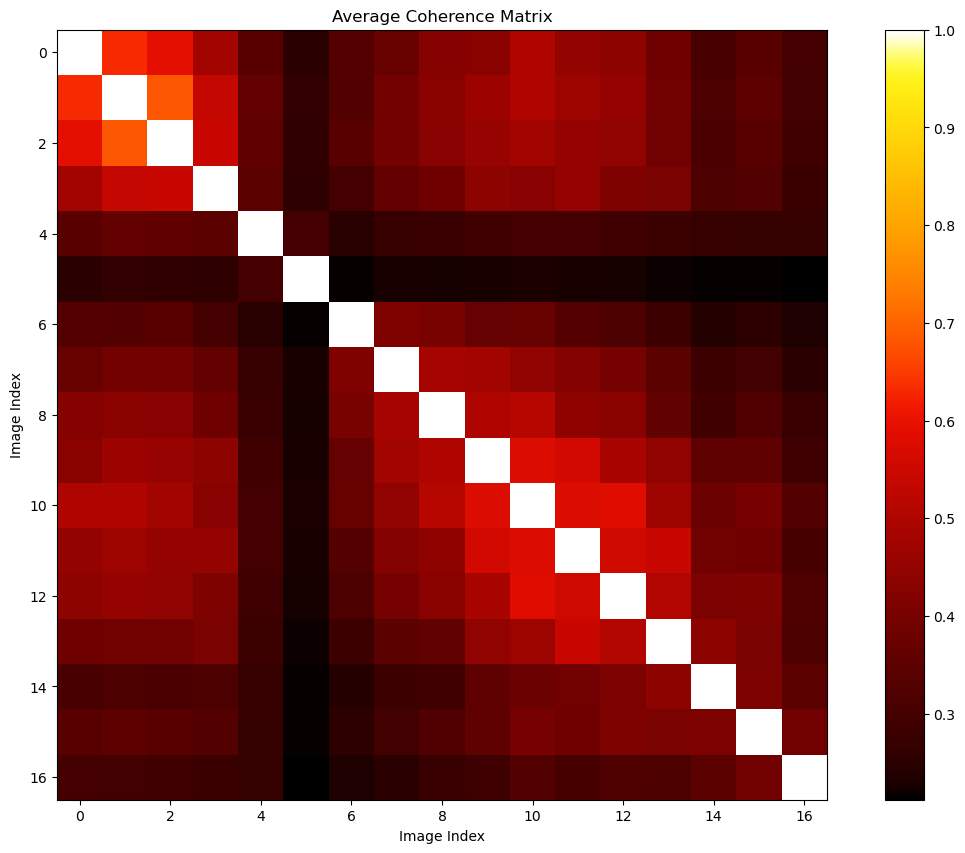

In [ ]:
%%time
de_emperical_co_sp(rslc,ds_can_is_shp,ds_can_idx,ds_can_coh,log=log,ds_can_coh_ave_fig=ds_can_coh_ave_fig)

In [ ]:
!de_emperical_co_sp -h

usage: de_emperical_co_sp [-h] [--az_chunk_size AZ_CHUNK_SIZE]
                          [--ds_can_coh_chunk_size DS_CAN_COH_CHUNK_SIZE]
                          [--ds_can_coh_ave_fig DS_CAN_COH_AVE_FIG] [--log LOG]
                          rslc is_shp is_ds_can ds_can_coh

positional arguments:
  rslc                                  input: rslc stack
  is_shp                                input: bool array indicating the SHPs of
                                        every pixel
  is_ds_can                             input: bool array indicating DS
                                        candidate
  ds_can_coh                            output: complex coherence matrix for DS
                                        candidate

options:
  -h, --help                            show this help message and exit
  --az_chunk_size AZ_CHUNK_SIZE         azimuth chunk size, optional. Default:
                                        the azimuth chunk size in rslc stack
  --ds_can_coh_chunk

In [ ]:
%%time
#| hide
import numpy as np
import zarr
import cupy as cp
from decorrelation.shp import ks_test
rslc_zarr = zarr.open('../../data/rslc.zarr',mode='r')
is_shp_zarr = zarr.open('./is_shp.zarr','r')
is_ds_can_zarr = zarr.open('./is_ds_can.zarr','r')
rslc_cpu = rslc_zarr[:]; rslc = cp.asarray(rslc_cpu)
is_shp_cpu = is_shp_zarr[:]; is_shp = cp.asarray(is_shp_cpu)
is_ds_can_cpu = is_ds_can_zarr[:]; is_ds_can = cp.asarray(is_ds_can_cpu)
ds_can_idx = cp.where(is_ds_can)
ds_can_is_shp = is_shp[is_ds_can]
ds_can_coh = emperical_co_sp(rslc,ds_can_idx,ds_can_is_shp)[1]

ds_can_coh_cpu = cp.asnumpy(ds_can_coh)
nimage = rslc.shape[-1]
ds_can_chunk_size = math.ceil(ds_can_coh.shape[0]/3)
# zarr.save_array('test_ds_can_coh.zarr', ds_can_coh_cpu,chunks=(ds_can_coh_chunk_size,nimage,nimage),compressor=None)

CPU times: user 1.74 s, sys: 1.18 s, total: 2.92 s
Wall time: 2.51 s


In [ ]:
#| hide
ds_can_coh_result = zarr.open('./ds_can_coh.zarr','r')[:]
ds_can_coh_test = zarr.open('./test_ds_can_coh.zarr','r')[:]
np.testing.assert_array_equal(ds_can_coh_cpu,ds_can_coh_result)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()